In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
from sklearn.metrics import accuracy_score,  f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, log_loss
import random
import time
import collections
import warnings
from scipy.stats import pearsonr, spearmanr

%matplotlib inline

In [100]:
train_tcga_df = pd.read_csv('/Users/shruti/Documents/train_tcga_expression_matrix_processed.tsv', header=0, sep='\t')
test_tcga_df = pd.read_csv('/Users/shruti/Documents/GitHub/Gene-compression-and-Cancer-type-classification/data/test_tcga_expression_matrix_processed.tsv', header=0, sep='\t')

labels_tcga_df = pd.read_csv('/Users/shruti/Documents/GitHub/Gene-compression-and-Cancer-type-classification/data/tcga_sample_identifiers.tsv', header=0, sep='\t')

In [101]:
train_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,3430.0,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,6050.0,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,4930.0,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,3890.0,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,1930.0,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0


In [102]:
test_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,2730.0,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,4510.0,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,4420.0,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,5460.0,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,5200.0,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0


In [103]:
labels_tcga_df.head()

,sample_id,sample_type,cancer_type
0,TCGA-02-0047-01,Primary Solid Tumor,GBM
1,TCGA-02-0055-01,Primary Solid Tumor,GBM
2,TCGA-02-2483-01,Primary Solid Tumor,GBM
3,TCGA-02-2485-01,Primary Solid Tumor,GBM
4,TCGA-02-2486-01,Primary Solid Tumor,GBM


In [104]:
train_id = train_tcga_df['sample_id']
test_id = test_tcga_df['sample_id']
label_id = labels_tcga_df['sample_id']

In [105]:
merge_train = []
merge_test = []

for i in train_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_train.append(str(val['cancer_type']).split()[1])
    
for i in test_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_test.append(str(val['cancer_type']).split()[1])

In [106]:
train_tcga_df['cancer_type'] = merge_train
train_tcga_df.head()
train_tcga_df.shape

(9954, 16150)

In [107]:
test_tcga_df['cancer_type'] = merge_test
test_tcga_df.head()
test_tcga_df.shape

(1106, 16150)

In [108]:
def approx_keras_binary_cross_entropy(x, z, p, epsilon=1e-07):
    """
    Function to approximate Keras `binary_crossentropy()`
    https://github.com/keras-team/keras/blob/e6c3f77b0b10b0d76778109a40d6d3282f1cadd0/keras/losses.py#L76
    Which is a wrapper for TensorFlow `sigmoid_cross_entropy_with_logits()`
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
    An important step is to clip values of reconstruction
    https://github.com/keras-team/keras/blob/a3d160b9467c99cbb27f9aa0382c759f45c8ee66/keras/backend/tensorflow_backend.py#L3071
    Arguments:
    x - Reconstructed input RNAseq data
    z - Input RNAseq data
    p - number of features
    epsilon - the clipping value to stabilize results (same Keras default)
    """
    # Ensure numpy arrays
    x = np.array(x)
    z = np.array(z)

    # Add clip to value
    x[x < epsilon] = epsilon
    x[x > (1 - epsilon)] = (1 - epsilon)

    # Perform logit
    x = np.log(x / (1 - x))

    # Return approximate binary cross entropy
    return np.mean(p * np.mean(- x * z + np.log(1 + np.exp(x)), axis=-1))

In [109]:
def returnDf2(c_type):
    df2  = train_tcga_df.drop(['sample_id'], axis=1)

    fraction = collections.Counter(merge_train)[c_type]/len(merge_train)

    df2_0 = df2[df2.cancer_type!=c_type]
    df2_0.loc[:,"cancer_type"] = 0
    df2_0 = df2_0.sample(frac = fraction)

    df2_1 = df2[df2.cancer_type==c_type]
    df2_1.loc[:,"cancer_type"] = 1

    df2 = pd.concat([df2_0, df2_1])
    df2["cancer_type"] = df2["cancer_type"].astype('int')

    return df2

In [110]:
def returnTest2(c_type):
    test2  = test_tcga_df.drop(['sample_id'], axis=1)

    fraction = collections.Counter(merge_test)[c_type]/len(merge_test)

    test2_0 = test2[test2.cancer_type!=c_type]
    test2_0.loc[:,"cancer_type"] = 0
    test2_0 = test2_0.sample(frac = fraction)

    test2_1 = test2[test2.cancer_type==c_type]
    test2_1.loc[:,"cancer_type"] = 1

    test2 = pd.concat([test2_0, test2_1])
    test2 = test2.astype('int')
    return test2

In [111]:
def runSVM(df2, test2):
    #first LR classifier with 16149 variables
    time_laps = []
    for i in range(4):
        start_time = time.time()
        clf = LogisticRegression(random_state=0).fit(df2.iloc[:,0:df2.shape[1]],df2["cancer_type"])
        pred = clf.predict(test2.iloc[:,0:test2.shape[1]])
        accuracy = accuracy_score(test2.cancer_type,pred)
        laps = time.time() - start_time
        time_laps.append(laps)
    avg_time_laps = np.mean(time_laps)
    SVM_accuracy = accuracy
    SVM_computation_time = avg_time_laps
    return SVM_accuracy, SVM_computation_time

In [117]:
def compile_reconstruction(nmf,ctype,k,test=False):
        """
        Compile reconstruction costs between input and algorithm reconstruction
        Arguments:
        Two dictionaries storing 1) reconstruction costs and 2) reconstructed
        matrix for each algorithm
        """
        
        
        if (test):
            input_df= pd.read_csv ('nmf/input_test_{}.csv'.format(ctype))
            input_df = input_df.iloc[: , 1:]
            pca_df= pd.read_csv('nmf/nmf_comp_test_{}_{}.csv'.format(ctype,k))
            pca_df = pca_df.iloc[: , 1:]
            key = 'test'
        else:
            input_df= pd.read_csv('nmf/input_train_{}.csv'.format(ctype))
            input_df = input_df.iloc[: , 1:]
            pca_df= pd.read_csv('nmf/nmf_comp_train_{}_{}.csv'.format(ctype,k))
            pca_df = pca_df.iloc[: , 1:]
            key= 'train'
        
        
        pca_reconstruct_mat = nmf.inverse_transform(pca_df)
        
        reconstruct_mat = pd.DataFrame(pca_reconstruct_mat,
                                              index=input_df.index,
                                              columns=input_df.columns)
        reconstruct_mat.to_csv ('nmf/reconstruct_mat_{}_{}_{}.csv'.format(key,ctype,k))


In [118]:
def returnNMF(df2, test2, ctype, k):
    warnings.filterwarnings("ignore")
    
    start_time = time.time()
    new = pd.concat([df2,test2],axis=0)
    standard = StandardScaler()
    
    result_train = standard.fit_transform(df2.iloc[:,0:df2.shape[1]])
    result_train = pd.DataFrame(result_train)
    scaler = MinMaxScaler()
    result_train=scaler.fit_transform(result_train.iloc[:,0:result_train.shape[1]])
    result_train = pd.DataFrame(result_train)
    result_train.to_csv ('nmf/input_train_{}.csv'.format(ctype))
    
    result_test = standard.fit_transform(test2.iloc[:,0:test2.shape[1]])
    result_test = pd.DataFrame(result_test)
    result_test=scaler.fit_transform(result_test.iloc[:,0:result_test.shape[1]])
    result_test = pd.DataFrame(result_test)
    result_test.to_csv ('nmf/input_test_{}.csv'.format(ctype))
    n_comp= min(k, result_train.shape[0])

    # PCA calculation
    nmf = NMF(n_components=n_comp)
    
    # PCA Model Fitting for Train Set
    nmf_comp_train = nmf.fit_transform(result_train)
    colnames = ['nmf_{}'.format(x) for x in range(0, n_comp)]
    nmf_comp_train = pd.DataFrame(nmf_comp_train,
                               columns=colnames,index=result_train.index)
    nmf_comp_train.to_csv ('nmf/nmf_comp_train_{}_{}.csv'.format(ctype,k))
    nmf_weights_train = pd.DataFrame(nmf.components_,
                                        columns=result_train.columns,
                                        index=colnames)
    nmf_weights_train.to_csv ('nmf/nmf_weights_train_{}_{}.csv'.format(ctype,k))
    nmf_time = time.time()-start_time
    
    # PCA Transform on the Test Set
    nmf_comp_test = nmf.transform(result_test)
    nmf_comp_test = pd.DataFrame(nmf_comp_test,
                               columns=colnames,index=result_test.index)
    nmf_comp_test.to_csv ('nmf/nmf_comp_test_{}_{}.csv'.format(ctype,k))

    # compile reconstruction 
    compile_reconstruction(nmf,ctype,k)
    compile_reconstruction(nmf,ctype,k,test=True)
    
    return nmf_comp_train, nmf_comp_test, nmf_time



In [119]:
def prepNMFClassifier(df2, test2, principal_comp_train, principal_comp_test):
    #y_col = pd.concat([df2.cancer_type,test2.cancer_type],axis=0)
    train_y= df2.cancer_type
    test_y=  test2.cancer_type
    
    train_x= principal_comp_train.iloc[:,0:principal_comp_train.shape[1]]
    test_x = principal_comp_test.iloc[:,0:principal_comp_test.shape[1]]
    
    #train_x,test_x,train_y,test_y = train_test_split(principal_comp.iloc[:,0:principal_comp.shape[1]],principal_comp.cancer_type,test_size=0.25)
    return train_x,test_x,train_y,test_y

In [120]:
# LR model after PCA

def NMFClassifier(train_x, train_y, test_x, test_y):
    com_time_laps=[]
    for i in range(4):
        start_time = time.time()
        clf2 = LogisticRegression(random_state=0).fit(train_x,train_y)
        pred= clf2.predict(test_x)
        accuracy = accuracy_score(pred,test_y)
        precision, recall, f1score, _= precision_recall_fscore_support(test_y, pred)
        time_laps_after_nmf = time.time() - start_time
        com_time_laps.append(time_laps_after_nmf)
        lis = [accuracy,np.mean(com_time_laps)]
    return accuracy, np.mean(com_time_laps), precision, recall, f1score

In [121]:
c_type_list = collections.Counter(merge_train)
# c_type_list = ['LUAD', 'LGG', 'PRAD', 'STAD']
#c_type_list = ['DLBC']
cols = ['cancer_type', 'Full-data acc.', 'Full-data comp. time', 'NMF components', 'NMF calc. time', 'NMF acc.','Precision', 'Recall', 'F1Score']

results_df = pd.DataFrame(columns = cols)
i = 0
num_latent_space= [2,5,10,20,50,100]
# num_latent_space= [100,150,200]
for k in num_latent_space:
    for c_type in c_type_list:
        print(str(k) + ", " + c_type)
        # train_data
        df2 = returnDf2(c_type)
        #test data
        test2 = returnTest2(c_type)
        # run LR on Entire datasaet 
        accuracy, avg_time_laps = runSVM(df2, test2)
        
        # calculate PCA and reconstruction 
        nmf_comp_train, nmf_comp_test, nmf_time\
        = returnNMF(df2, test2, c_type, k)
        
        # get train test split
        train_x,test_x,train_y,test_y = prepNMFClassifier(df2, test2, nmf_comp_train, nmf_comp_test)
        
        # run LR on principal components
        nmf_acc, nmf_time, precision, recall, f1score = NMFClassifier(train_x, train_y, test_x, test_y)
        
        results_df.loc[i] = [c_type, accuracy,avg_time_laps, nmf_comp_test.shape[1],nmf_time,  nmf_acc,precision, recall, f1score ]
        i = i+1


2, BRCA
2, LUAD
2, DLBC
2, UCEC
2, SKCM
2, PRAD
2, HNSC
2, KIRP
2, CESC
2, THCA
2, KIRC
2, STAD
2, COAD
2, READ
2, LGG
2, MESO
2, LAML
2, BLCA
2, OV
2, LUSC
2, ACC
2, THYM
2, ESCA
2, PAAD
2, LIHC
2, SARC
2, GBM
2, TGCT
2, KICH
2, PCPG
2, UCS
2, UVM
2, CHOL
5, BRCA
5, LUAD
5, DLBC
5, UCEC
5, SKCM
5, PRAD
5, HNSC
5, KIRP
5, CESC
5, THCA
5, KIRC
5, STAD
5, COAD
5, READ
5, LGG
5, MESO
5, LAML
5, BLCA
5, OV
5, LUSC
5, ACC
5, THYM
5, ESCA
5, PAAD
5, LIHC
5, SARC
5, GBM
5, TGCT
5, KICH
5, PCPG
5, UCS
5, UVM
5, CHOL
10, BRCA
10, LUAD
10, DLBC
10, UCEC
10, SKCM
10, PRAD
10, HNSC
10, KIRP
10, CESC
10, THCA
10, KIRC
10, STAD
10, COAD
10, READ
10, LGG
10, MESO
10, LAML
10, BLCA
10, OV
10, LUSC
10, ACC
10, THYM
10, ESCA
10, PAAD
10, LIHC
10, SARC
10, GBM
10, TGCT
10, KICH
10, PCPG
10, UCS
10, UVM
10, CHOL
20, BRCA
20, LUAD
20, DLBC
20, UCEC
20, SKCM
20, PRAD
20, HNSC
20, KIRP
20, CESC
20, THCA
20, KIRC
20, STAD
20, COAD
20, READ
20, LGG
20, MESO
20, LAML
20, BLCA
20, OV
20, LUSC
20, ACC
20, THYM
20

In [122]:
results_df


,cancer_type,Full-data acc.,Full-data comp. time,NMF components,NMF calc. time,NMF acc.,Precision,Recall,F1Score
0,BRCA,0.974026,3.168041,2,0.017477,0.692641,"[0.7435897435897436, 0.6666666666666666]","[0.5321100917431193, 0.8360655737704918]","[0.6203208556149734, 0.7418181818181817]"
1,LUAD,0.981982,1.410475,2,0.009860,0.486486,"[0.4864864864864865, 0.0]","[1.0, 0.0]","[0.6545454545454547, 0.0]"
2,DLBC,1.000000,0.267052,2,0.003368,0.900000,"[0.8333333333333334, 1.0]","[1.0, 0.8]","[0.9090909090909091, 0.888888888888889]"
3,UCEC,0.954128,1.390892,2,0.025534,0.688073,"[0.9130434782608695, 0.627906976744186]","[0.39622641509433965, 0.9642857142857143]","[0.5526315789473684, 0.7605633802816901]"
4,SKCM,0.978261,2.837626,2,0.008713,0.641304,"[0.7142857142857143, 0.609375]","[0.4444444444444444, 0.8297872340425532]","[0.5479452054794521, 0.7027027027027027]"
...,...,...,...,...,...,...,...,...,...
193,KICH,0.900000,0.376550,100,0.006167,0.900000,"[0.9, 0.9]","[0.9, 0.9]","[0.9, 0.9]"
194,PCPG,1.000000,0.375493,100,0.008687,0.973684,"[0.95, 1.0]","[1.0, 0.9473684210526315]","[0.9743589743589743, 0.972972972972973]"
195,UCS,0.833333,0.266031,100,0.004643,0.833333,"[0.8333333333333334, 0.8333333333333334]","[0.8333333333333334, 0.8333333333333334]","[0.8333333333333334, 0.8333333333333334]"
196,UVM,1.000000,0.322240,100,0.004624,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"


In [143]:
# list1=[2,10]
results_df.loc[results_df['NMF components']==int(50)]



,cancer_type,Full-data acc.,Full-data comp. time,NMF components,NMF calc. time,NMF acc.,Precision,Recall,F1Score
132,BRCA,0.974026,2.166218,50,0.015266,0.982684,"[0.972972972972973, 0.9916666666666667]","[0.9908256880733946, 0.9754098360655737]","[0.9818181818181818, 0.9834710743801653]"
133,LUAD,0.981982,1.625208,50,0.016468,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
134,DLBC,1.000000,0.295966,50,0.003992,1.000000,"[1.0, 1.0]","[1.0, 1.0]","[1.0, 1.0]"
135,UCEC,0.963303,1.438773,50,0.014917,0.972477,"[0.9629629629629629, 0.9818181818181818]","[0.9811320754716981, 0.9642857142857143]","[0.9719626168224299, 0.972972972972973]"
136,SKCM,0.978261,1.163914,50,0.010132,0.989130,"[0.9782608695652174, 1.0]","[1.0, 0.9787234042553191]","[0.989010989010989, 0.989247311827957]"
137,PRAD,1.000000,0.782129,50,0.014590,0.990654,"[0.9811320754716981, 1.0]","[1.0, 0.9818181818181818]","[0.9904761904761905, 0.9908256880733944]"
138,HNSC,0.972477,1.679422,50,0.013100,0.944954,"[0.9122807017543859, 0.9807692307692307]","[0.9811320754716981, 0.9107142857142857]","[0.9454545454545454, 0.9444444444444444]"
139,KIRP,0.907692,0.786301,50,0.013107,0.923077,"[0.9655172413793104, 0.8888888888888888]","[0.875, 0.9696969696969697]","[0.9180327868852458, 0.927536231884058]"
140,CESC,0.950820,1.129692,50,0.007824,0.868852,"[0.8235294117647058, 0.9259259259259259]","[0.9333333333333333, 0.8064516129032258]","[0.8749999999999999, 0.8620689655172414]"
141,THCA,1.000000,0.900924,50,0.013287,0.991304,"[0.9824561403508771, 1.0]","[1.0, 0.9830508474576272]","[0.9911504424778761, 0.9914529914529915]"


In [123]:
results_df.to_csv ('nmf/nmf_accuracy_results.csv')

## Metrics Evaluation

In [144]:
# metrics evaluation 

def calc_reconstruct_loss(k,ctype,test= False): 
    if test:
        key='test'
    else:
        key= 'train'
    input_df= pd.read_csv ('nmf/input_{}_{}.csv'.format(key,ctype))
    input_df = input_df.iloc[: , 1:]
    reconstruct_mat= pd.read_csv ('nmf/reconstruct_mat_{}_{}_{}.csv'.format(key,ctype,k))
    reconstruct_mat = reconstruct_mat.iloc[: , 1:]
    
    loss = np.sum((input_df - reconstruct_mat) ** 2, axis=1).mean()
    
#     pca_recon_loss = approx_keras_binary_cross_entropy(reconstruct_mat, input_df,k)
    
    return loss
    

In [157]:
num_latent_space= [2,5,10,20,50,100]

#testing loss
k_loss =[]
class_wise_loss=[]

for k in num_latent_space:
    print(k)
    class_loss=[]
    for c_type in c_type_list:
        #mse loss
        loss=calc_reconstruct_loss(k,c_type,test=True)
        class_loss.append(loss)
    class_wise_loss.append(class_loss)
    k_loss.append(np.mean(class_loss))
print(np.array(k_loss).shape)   
print(np.array(class_wise_loss).shape)

2
5
10
20
50
100
(6,)
(6, 33)


In [158]:
num_latent_space= [2,5,10,20,50,100]

#training loss
k_loss_train =[]
class_wise_loss_train=[]

for k in num_latent_space:
    print(k)
    class_loss=[]
    for c_type in c_type_list:
        #mse loss
        loss=calc_reconstruct_loss(k,c_type)
        class_loss.append(loss)
    class_wise_loss_train.append(class_loss)
    k_loss_train.append(np.mean(class_loss))
print(np.array(k_loss_train).shape)   
print(np.array(class_wise_loss_train).shape)

2
5


KeyboardInterrupt: 

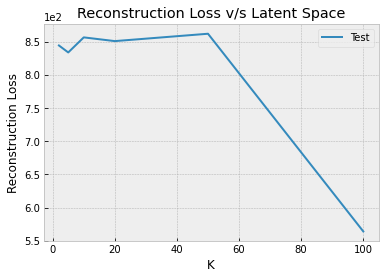

In [159]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, k_loss, label = "Test")

# plt.plot(num_latent_space, k_loss_train, label = "Train")

path = '/Users/shruti/Documents/GitHub/Gene-compression-and-Cancer-type-classification/figure/reconstuction_nmf'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Reconstruction Loss')

plt.title('Reconstruction Loss v/s Latent Space')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.savefig(path)
plt.legend()
plt.show()


No handles with labels found to put in legend.


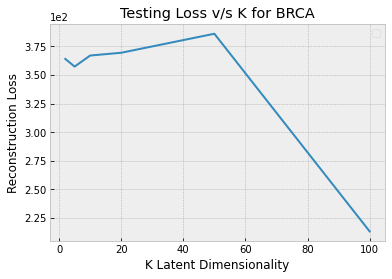

No handles with labels found to put in legend.


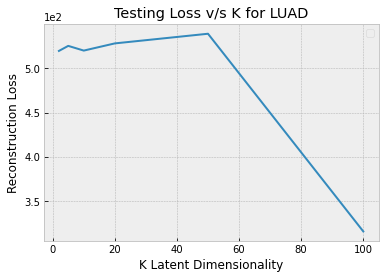

No handles with labels found to put in legend.


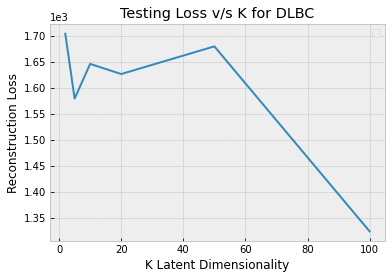

No handles with labels found to put in legend.


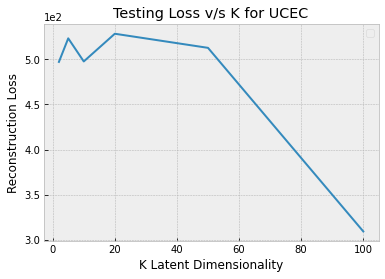

No handles with labels found to put in legend.


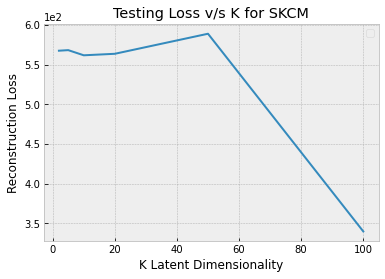

No handles with labels found to put in legend.


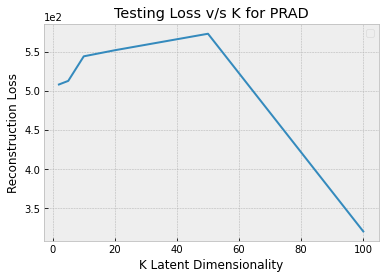

No handles with labels found to put in legend.


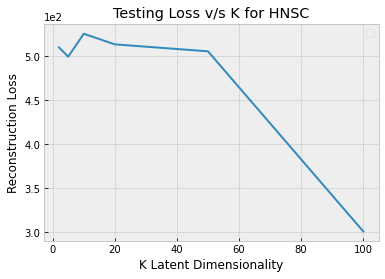

No handles with labels found to put in legend.


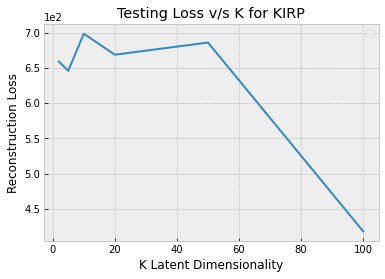

No handles with labels found to put in legend.


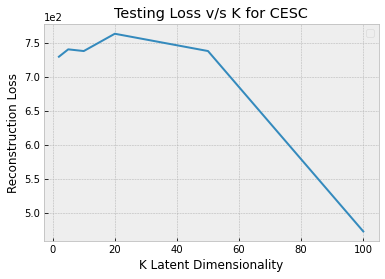

No handles with labels found to put in legend.


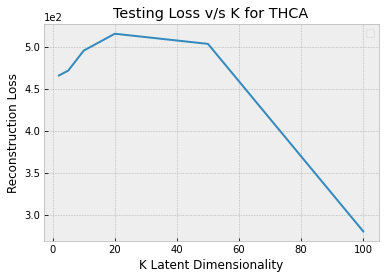

No handles with labels found to put in legend.


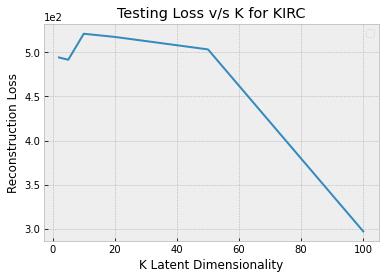

No handles with labels found to put in legend.


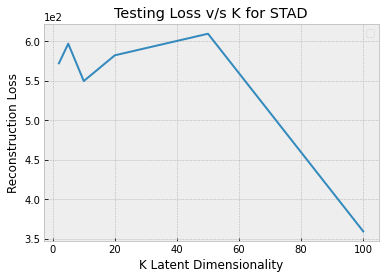

No handles with labels found to put in legend.


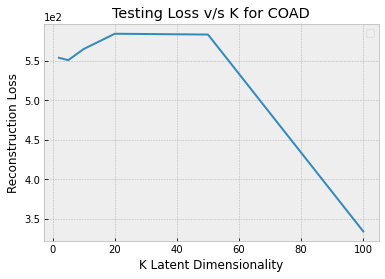

No handles with labels found to put in legend.


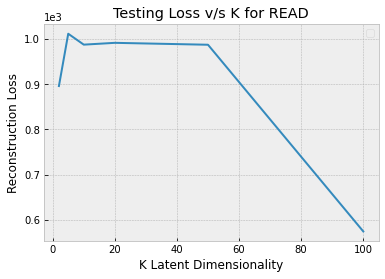

No handles with labels found to put in legend.


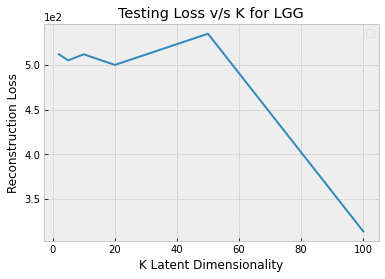

No handles with labels found to put in legend.


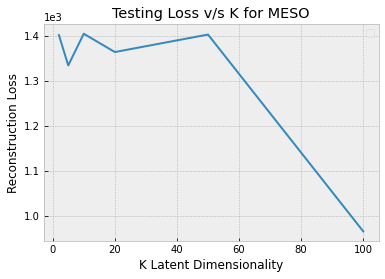

No handles with labels found to put in legend.


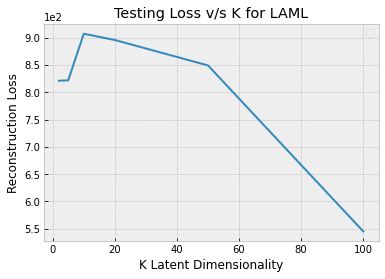

No handles with labels found to put in legend.


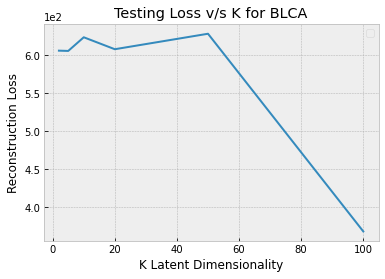

No handles with labels found to put in legend.


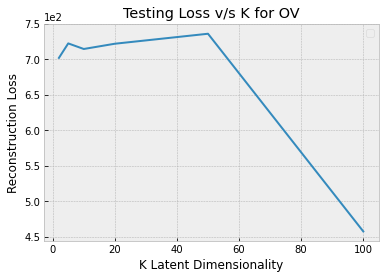

No handles with labels found to put in legend.


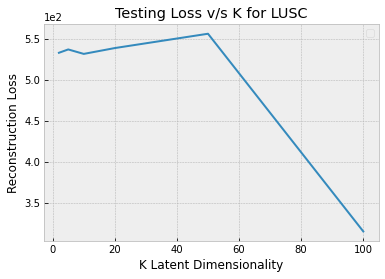

No handles with labels found to put in legend.


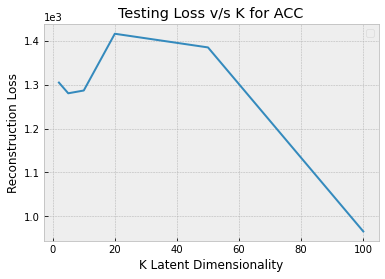

No handles with labels found to put in legend.


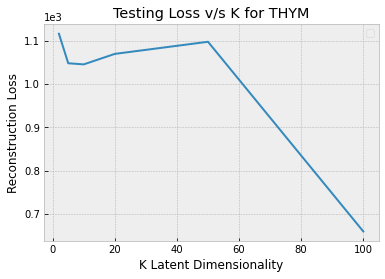

No handles with labels found to put in legend.


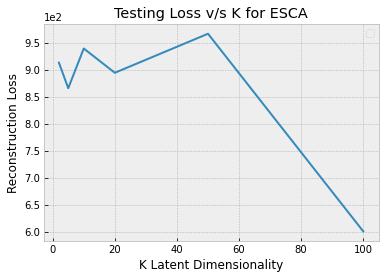

No handles with labels found to put in legend.


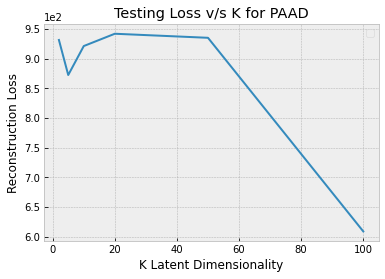

No handles with labels found to put in legend.


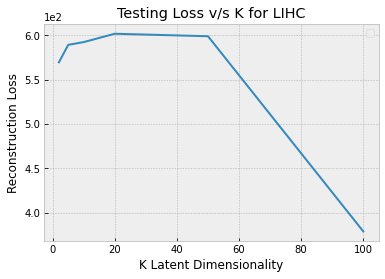

No handles with labels found to put in legend.


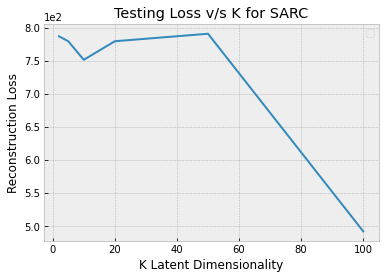

No handles with labels found to put in legend.


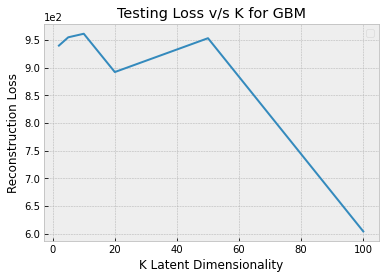

No handles with labels found to put in legend.


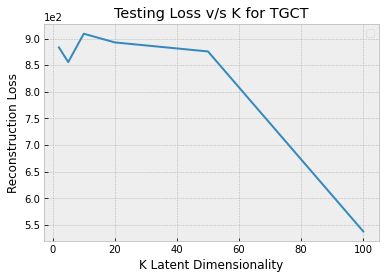

No handles with labels found to put in legend.


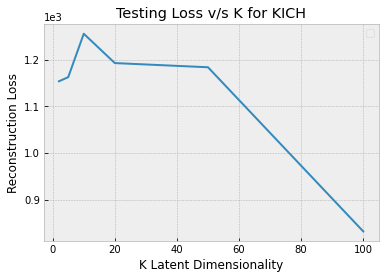

No handles with labels found to put in legend.


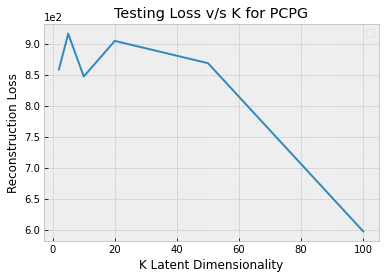

No handles with labels found to put in legend.


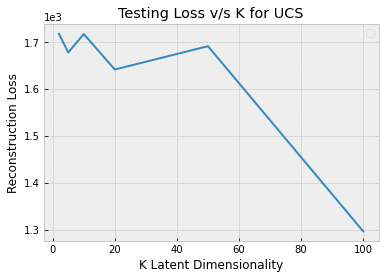

No handles with labels found to put in legend.


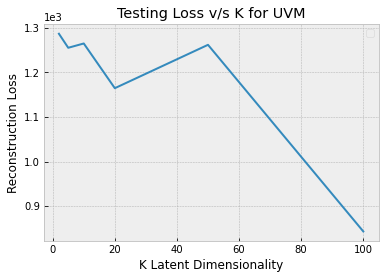

No handles with labels found to put in legend.


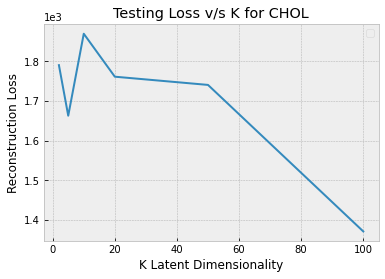

In [162]:
# plot class wise reconstruction loss graph 
#clean_labels= ['PRAD','THCA','LIHC']
label=[]
for key in c_type_list:
    label.append(key)
class_wise_loss=np.array(class_wise_loss)
# class_wise_loss_train=np.array(class_wise_loss_train)
for ctype in range(len(c_type_list)):
    
    
    k_loss= class_wise_loss[:,ctype]
    plt.plot(num_latent_space, k_loss)


    # plt.plot(x2, y2, label = "Training")

    # naming the x axis
    plt.xlabel('K Latent Dimensionality')
    # naming the y axis
    plt.ylabel('Reconstruction Loss')
    # giving a title to my graph
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.title('Testing Loss v/s K for {}'.format(label[ctype]))

    plt.legend()
    plt.show()

In [149]:
def calc_pearson(k, ctype, test= False):
    
    if test:
        key='test'
    else:
        key= 'train'
        
    input_df= pd.read_csv ('nmf/input_{}_{}.csv'.format(key,ctype))
    input_df = input_df.iloc[: , 1:]
    reconstruct_mat= pd.read_csv ('nmf/reconstruct_mat_{}_{}_{}.csv'.format(key,ctype,k))
    reconstruct_mat = reconstruct_mat.iloc[: , 1:]
    
    r = [pearsonr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]
    
    return r
    

In [150]:
# calculate test pearson correlation values
num_latent_space= [2,5,10,20,50,100]

#testing correlation values
k_pearson =[]
class_wise_pearson=[]

for k in num_latent_space:
    print(k)
    class_corr=[]
    for c_type in c_type_list:
        #mse loss
        pearson=calc_pearson(k,c_type,test=True)
        class_corr.append(pearson)
        
    class_wise_pearson.append(class_corr)
    
print(np.array(class_wise_pearson).shape)


2
5
10
20
50
100
(6, 33)


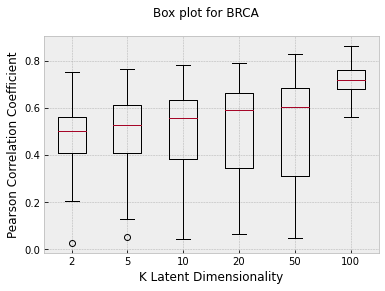

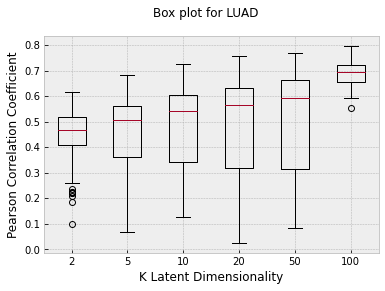

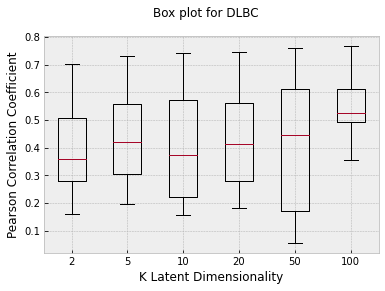

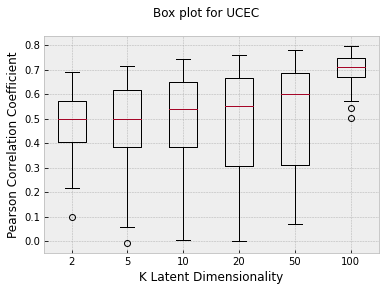

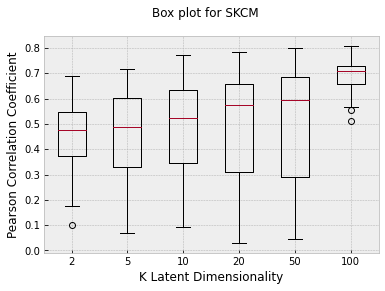

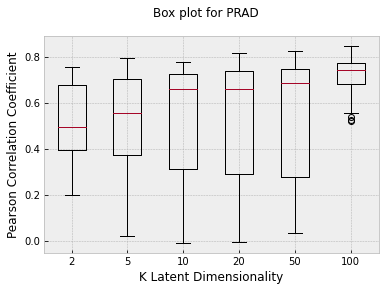

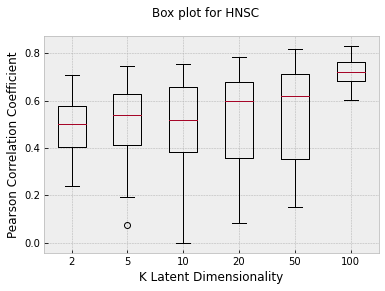

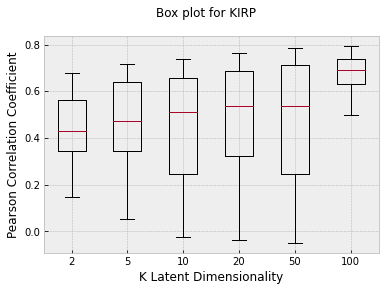

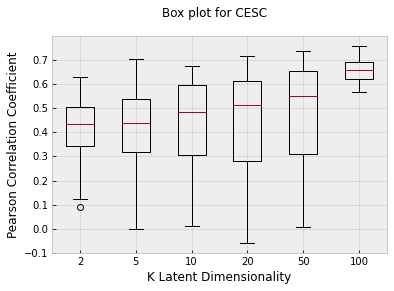

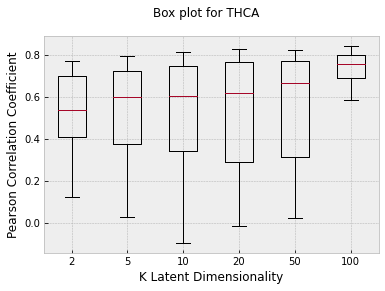

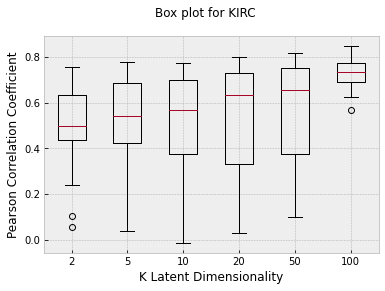

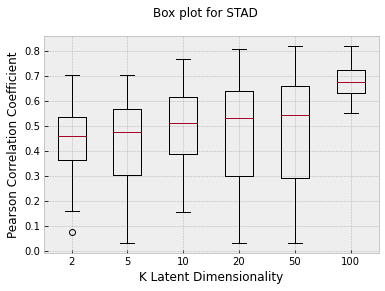

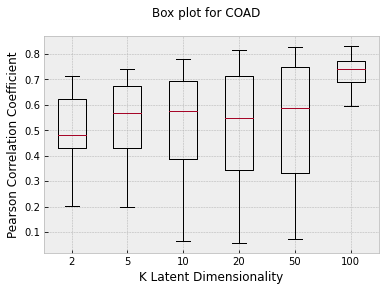

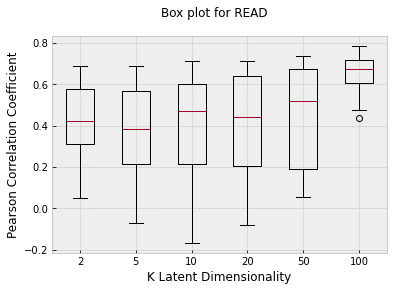

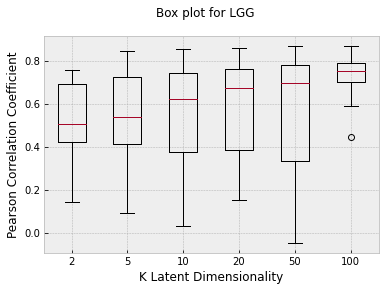

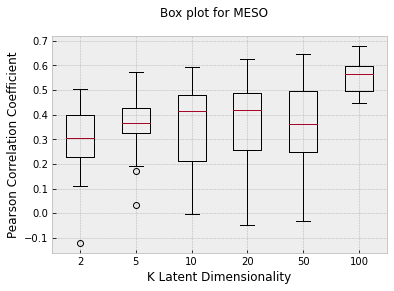

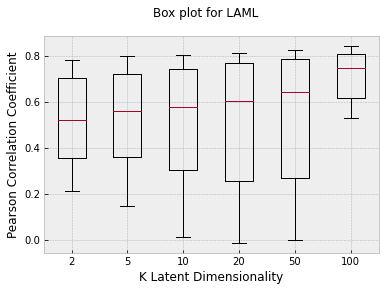

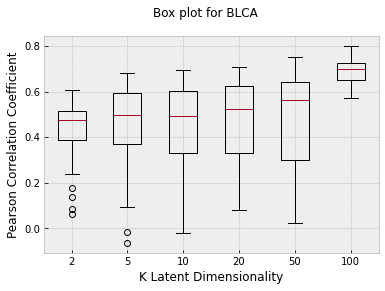

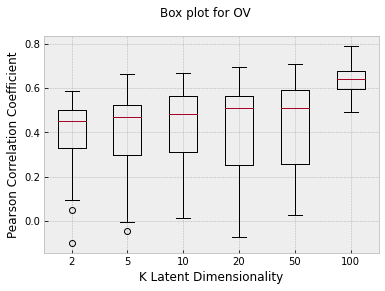

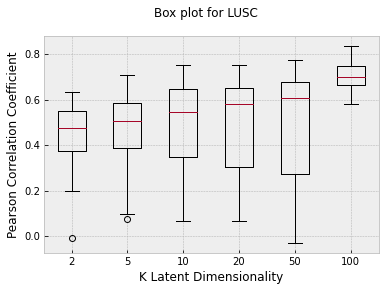

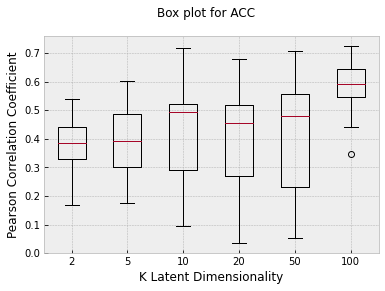

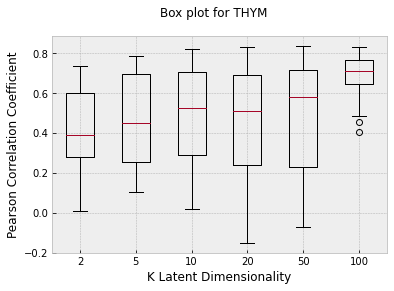

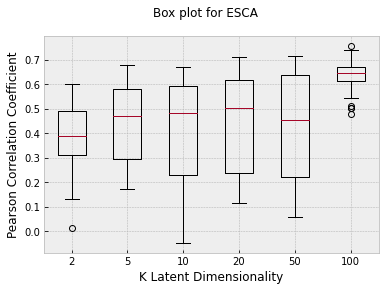

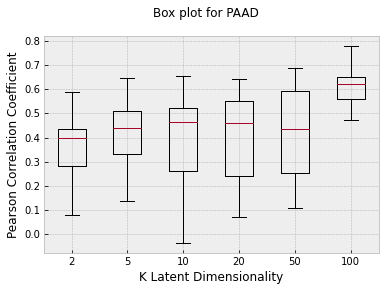

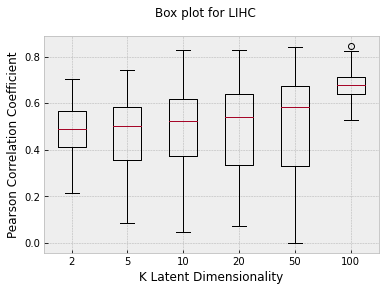

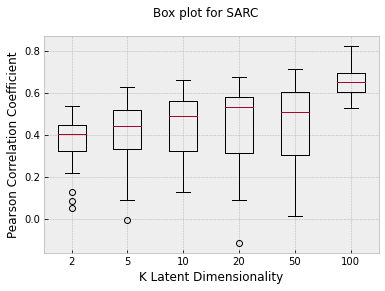

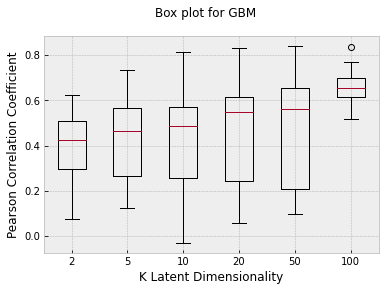

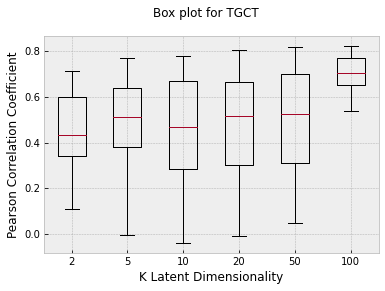

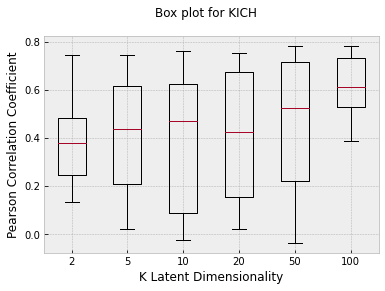

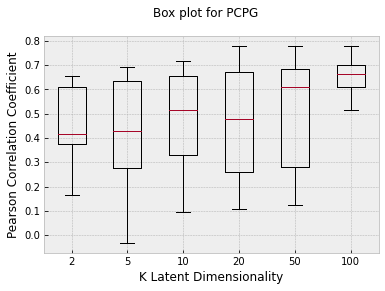

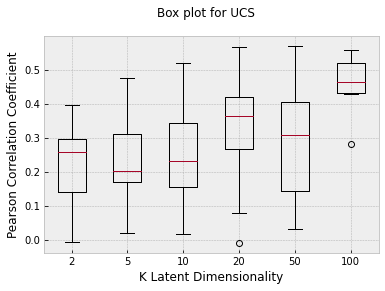

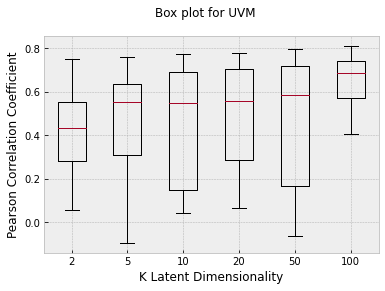

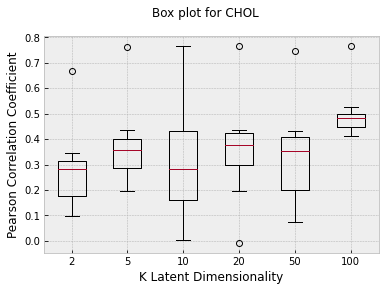

In [163]:
# plot class wise pearson correlation graph 
#clean_labels_for_plot = ['LUAD','CESC','LGG','LUSC']
label=[]
for key in c_type_list:
    label.append(key)
class_wise_pearson=np.array(class_wise_pearson)

num_latent_space=np.array(num_latent_space)
c_pearson=[]

for j in range(0,len(c_type_list)):
    c_pearson=[]
    for i in range(0,len(num_latent_space)):
        a=class_wise_pearson[i][j]
        c_pearson.append(a)
        
    # plot the box plot of the calculated pearson values
    c_pearson= np.array(c_pearson)
    fig, ax = plt.subplots() 
    fig.suptitle('Box plot for '+ label[j]) 
    ax.set_xlabel('K Latent Dimensionality') 
    ax.set_ylabel('Pearson Correlation Coefficient') 
    ax.boxplot(np.transpose(c_pearson), labels= num_latent_space) 
    #     fig.savefig(pearson_path)
    #     fig.clear(True) 
    

In [152]:
def calc_spearman(k, ctype, test= False):
    
    if test:
        key='test'
    else:
        key= 'train'
        
    input_df= pd.read_csv ('nmf/input_{}_{}.csv'.format(key,ctype))
    input_df = input_df.iloc[: , 1:]
    reconstruct_mat= pd.read_csv ('nmf/reconstruct_mat_{}_{}_{}.csv'.format(key,ctype,k))
    reconstruct_mat = reconstruct_mat.iloc[: , 1:]

    s = [spearmanr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]
    
    return s
    

In [153]:
# calculate test spearman correlation values
num_latent_space= [2,5,10,20,50,100]

#testing correlation values
k_spearman =[]
class_wise_spearman=[]

for k in num_latent_space:
    print(k)
    class_corr=[]
    for c_type in c_type_list:
        #mse loss
        spearman=calc_spearman(k,c_type,test=True)
        class_corr.append(spearman)
        
    class_wise_spearman.append(class_corr)
    
print(np.array(class_wise_spearman).shape)


2
5
10
20
50
100
(6, 33)


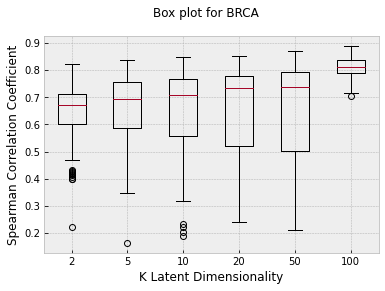

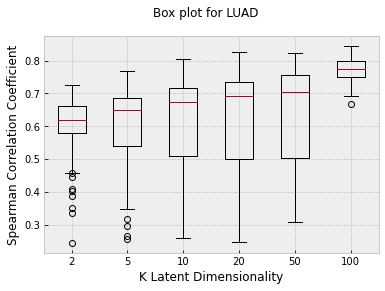

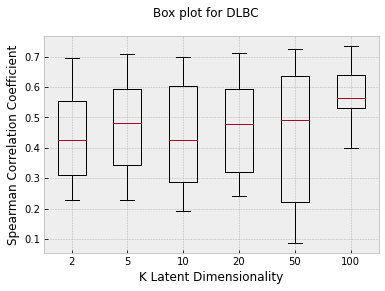

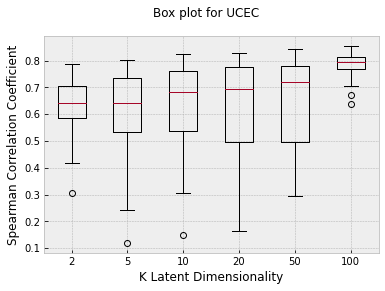

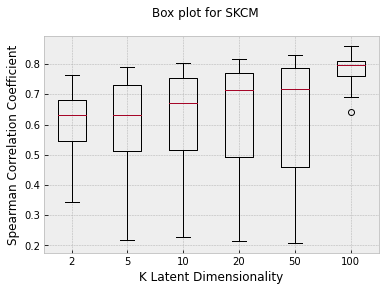

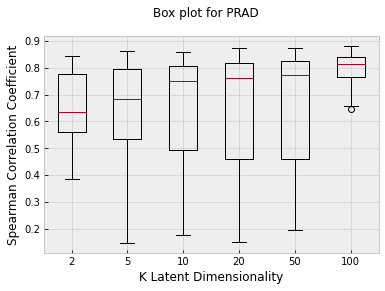

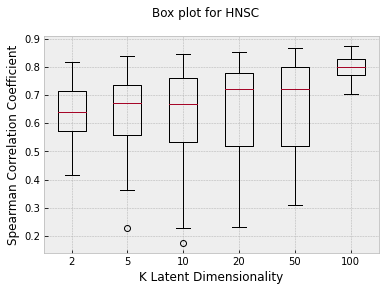

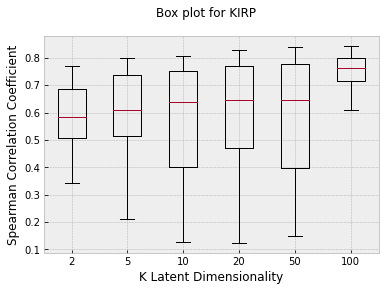

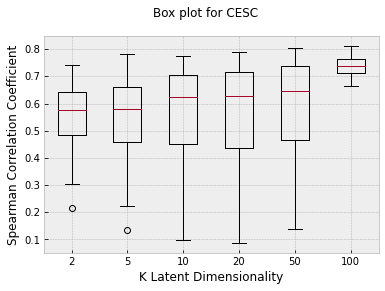

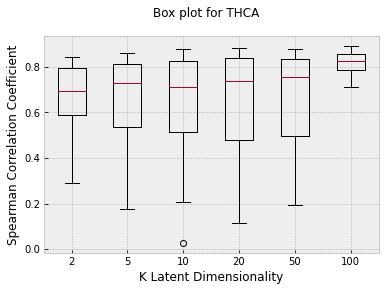

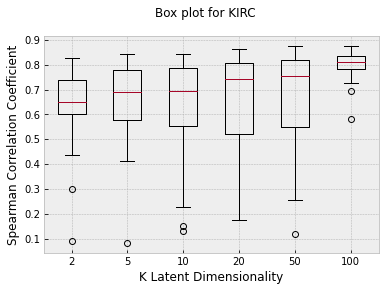

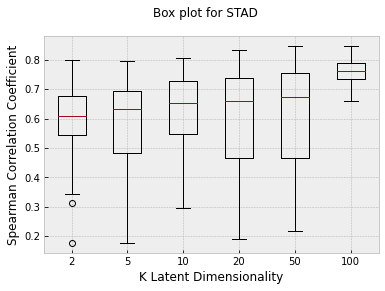

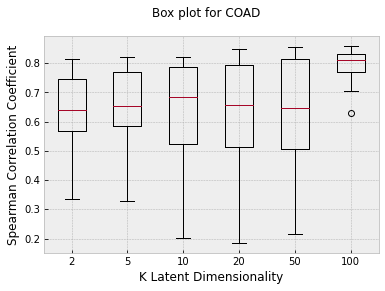

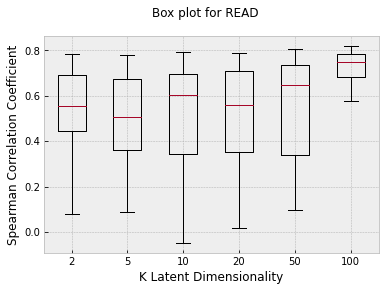

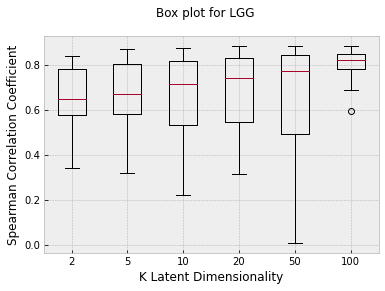

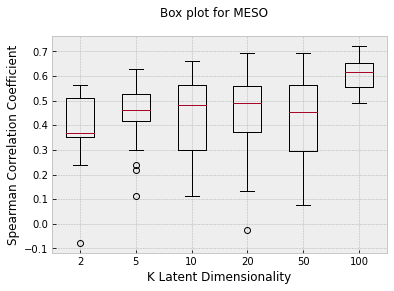

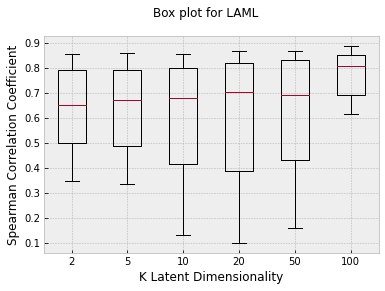

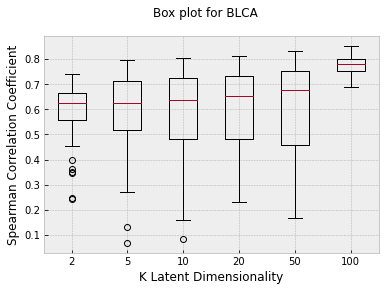

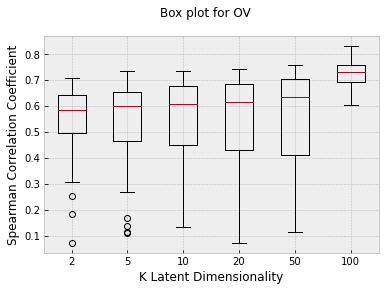

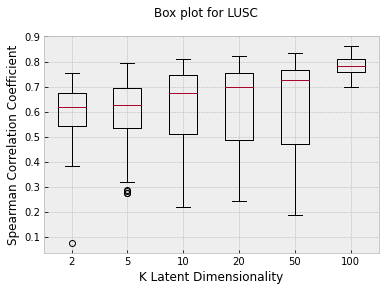

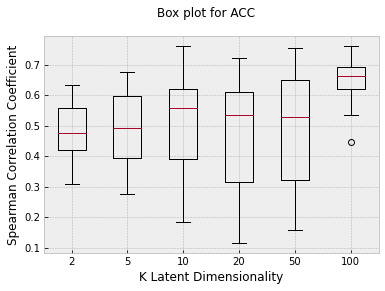

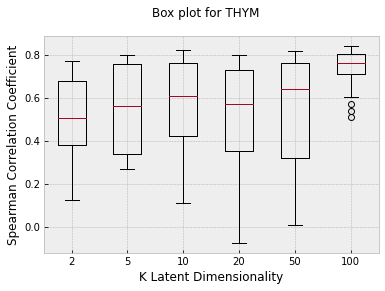

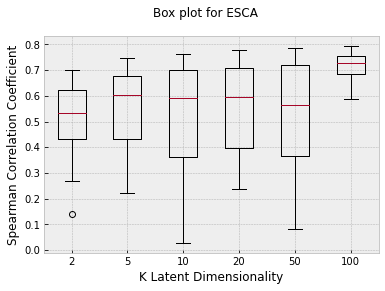

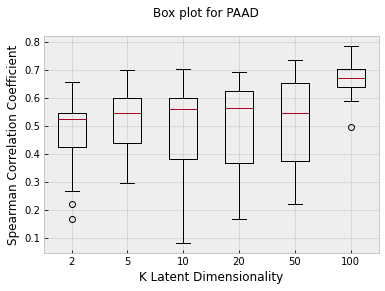

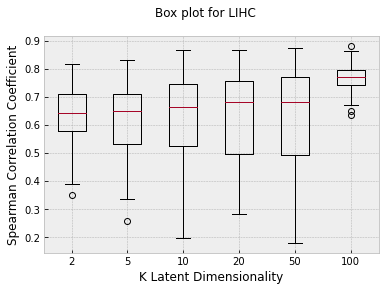

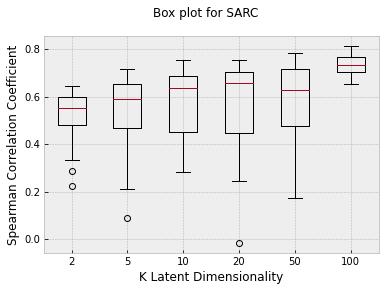

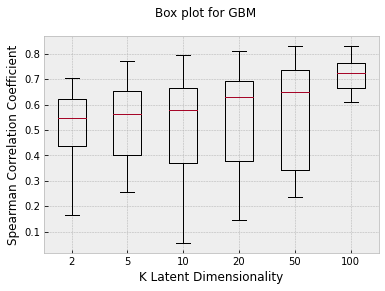

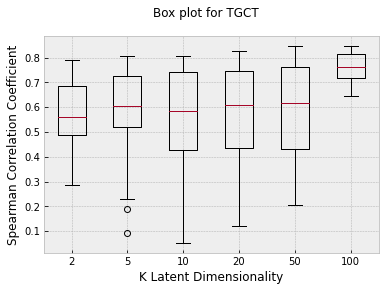

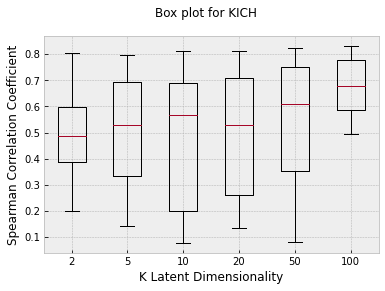

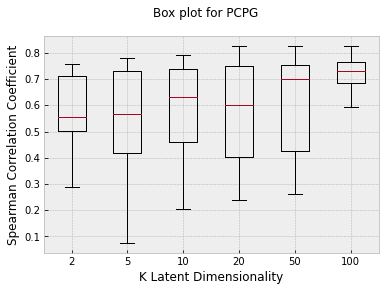

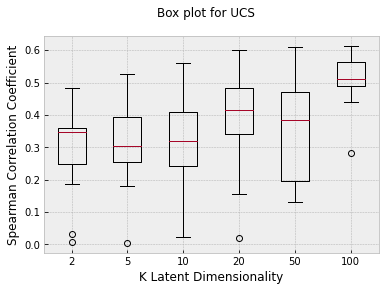

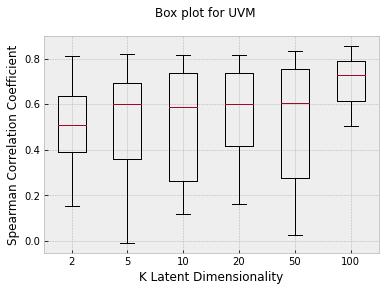

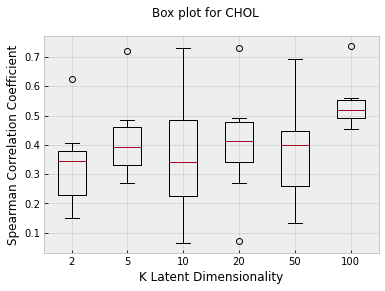

In [164]:
# plot class wise spearman correlation graph 
#clean_labels_for_plot = ['LUAD','CESC','LGG','LUSC']
label=[]
for key in c_type_list:
    label.append(key)
class_wise_spearman=np.array(class_wise_spearman)

num_latent_space=np.array(num_latent_space)
c_spearman=[]

for j in range(0,len(c_type_list)):
    c_spearman=[]
    for i in range(0,len(num_latent_space)):
        a=class_wise_spearman[i][j]
        c_spearman.append(a)
        
    # plot the box plot of the calculated pearson values
    c_spearman= np.array(c_spearman)
    fig, ax = plt.subplots() 
    fig.suptitle('Box plot for '+ label[j]) 
    ax.set_xlabel('K Latent Dimensionality') 
    ax.set_ylabel('Spearman Correlation Coefficient') 
    ax.boxplot(np.transpose(c_spearman), labels= num_latent_space) 
    #     fig.savefig(pearson_path)
    #     fig.clear(True) 
    